In [1]:
#Usual Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Wrangling
We perform the data wrangling steps previously detailed in the Data Story step.

In [2]:
billboard_data = pd.read_csv("all_charts.csv",low_memory=False)
spotify_data = pd.read_csv("audio_features.csv")
billboard_lyrics = pd.read_csv("all_lyrics.csv",encoding='latin1')
billboard_sub = billboard_data[["chartDate","title","artist","peakPos","lastPos","weeks","rank","change","spotifyID"]]
spotify_sub = spotify_data[["acousticness", "danceability", "duration_ms", "energy", "id","instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature","valence"]]
merged_data=pd.merge(billboard_sub,spotify_sub, how="outer",left_on="spotifyID",right_on="id")
#Replace weird characters:
merged_data=merged_data.replace({'\x83': '?'}, regex=True).replace({'\x82': '?'}, regex=True).replace({'\x80\x9c': '??'}, regex=True)
lyrics_sub=billboard_lyrics[["artist","lyrics","track","source"]]
big_dataset=pd.merge(merged_data, lyrics_sub,  how="outer",left_on=["artist","title"],right_on=["artist", "track"])
year = big_dataset.chartDate.replace({'-': ''}, regex=True)
year = year.apply(np.float)
year = year//10000
pd.set_option('precision', 0)
year=year.rename("year")
year_data=pd.concat([big_dataset,year],axis=1)

We now create a column counting the number of weeks a song charts in the top ten and how many weeks the song charts in the bottom 90.

In [3]:
top_ten_weeks=year_data[year_data['rank']<=10]
bottom_ninety_weeks=year_data[year_data['rank']>10]
no_year_cols=["title","artist","peakPos",'acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence']
group_columns = ["title","artist","peakPos",'acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','year']

In [4]:
top_ten_group=top_ten_weeks.groupby(no_year_cols).size().reset_index()
bottom_ninety_group=bottom_ninety_weeks.groupby(no_year_cols).size().reset_index()
# Rename column
top_ten_group.rename(columns={0:'num_weeks_top_ten'}, inplace=True)
bottom_ninety_group.rename(columns={0:'num_weeks_bottom'}, inplace=True)
# Join the top ten and bottom ninety together.
ten_ninety_join=pd.merge(top_ten_group,bottom_ninety_group, how="outer",left_on=no_year_cols,right_on=no_year_cols)
# Replace NaN's in the num_weeks_top_ten column with zeros.
ten_ninety_join=ten_ninety_join.fillna(0)
# Create a dataframe of all the unique songs with the year column.
songs_with_year=year_data.groupby(group_columns).size().reset_index()
# Remove the duplicate tracks for songs that appear in the charts for two separate year by choosing the first year. 
top_ten_yearly=songs_with_year.groupby(no_year_cols).min().reset_index()
# Merge the ten_ninety_join and top_ten_yearly datasets together.
hits_with_year=pd.merge(ten_ninety_join,top_ten_yearly, how="outer",left_on=no_year_cols,right_on=no_year_cols)

# Song Popularity Prediction
For the purposes of this project we say that a song is popular if it reaches the top ten, this is given by songs with 'num_weeks_top_ten'>0. We separate the songs into two categories and then keep only the songs for which we have Spotify audio metadata. Here, we use a binary classifier in the 'top_ten_hit' column.

In [5]:
# Create the top_ten_hit predictor column.
top_ten_prediction=hits_with_year[['peakPos', 'acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','year','num_weeks_top_ten',"num_weeks_bottom"]]
top_ten_prediction['top_ten_hit']= (top_ten_prediction.num_weeks_top_ten >0).astype(int)

C:\Users\MSI_USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [6]:
top_ten_prediction.groupby(['top_ten_hit']).mean().reset_index()

,top_ten_hit,peakPos,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,year,num_weeks_top_ten,num_weeks_bottom
0,0,53,3e-01,6e-01,219173,6e-01,4e-02,5,2e-01,-9,7e-01,7e-02,12,4,6e-01,1985,0,10
1,1,5,3e-01,6e-01,225462,6e-01,4e-02,5,2e-01,-9,7e-01,6e-02,12,4,6e-01,1983,6,14


From this initial investigation it seems like there is very little difference between the audio metadata features between songs making the Top Ten and songs that do not. However, from our previous observations of the averages over time we know that for certain years the averages between top ten hits and songs in the bottom ninety can differ significantly.

# Data Visualization

The key variable is an integer between zero and eleven and time signature is an integer between 2 and 5. These are not on a numerical scale so we introduce dummy indicator variables to distinguish between the cases when using regression.

In [7]:
# Change key and time entries to integers
top_ten_prediction.key=top_ten_prediction.key.astype(int)
top_ten_prediction.time_signature=top_ten_prediction.time_signature.astype(int)
# create dummy variables using get_dummies, then exclude the first dummy column
key_dummies = pd.get_dummies(top_ten_prediction.key, prefix='key').iloc[:, 1:]
time_dummies = pd.get_dummies(top_ten_prediction.time_signature, prefix='time').iloc[:, 1:]
# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
top_ten_no_na_dum = pd.concat([top_ten_prediction, key_dummies,time_dummies], axis=1)

C:\Users\MSI_USER\Anaconda3\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [8]:
top_ten_no_na_dum.head(10)

,peakPos,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,...,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_3,time_4,time_5
0,4,3e-01,9e-01,204933,7e-01,0e+00,9,2e-01,-4e+00,0,...,0,0,0,0,1,0,0,0,1,0
1,6,4e-01,6e-01,219813,7e-01,6e-06,2,1e-01,-4e+00,0,...,0,0,0,0,0,0,0,0,1,0
2,4,6e-01,6e-01,143867,4e-01,0e+00,10,4e-01,-1e+01,0,...,0,0,0,0,0,1,0,0,1,0
3,1,2e-03,5e-01,233987,1e+00,0e+00,1,1e-01,-9e-01,1,...,0,0,0,0,0,0,0,0,1,0
4,4,7e-03,8e-01,286712,7e-01,1e-06,1,3e-01,-8e+00,1,...,0,0,0,0,0,0,0,0,1,0
5,1,8e-02,5e-01,394133,4e-01,5e-05,1,7e-02,-1e+01,1,...,0,0,0,0,0,0,0,0,1,0
6,8,4e-01,5e-01,243493,5e-01,0e+00,10,1e-01,-8e+00,1,...,0,0,0,0,0,1,0,0,1,0
7,1,5e-01,7e-01,215600,4e-01,6e-06,4,1e-01,-1e+01,1,...,0,0,0,0,0,0,0,0,1,0
8,1,4e-02,7e-01,222973,9e-01,7e-02,2,1e-01,-7e+00,1,...,0,0,0,0,0,0,0,0,1,0
9,1,1e-02,6e-01,278627,7e-01,8e-05,11,7e-02,-1e+01,0,...,0,0,0,0,0,0,1,0,1,0


We check the histograms to see how they are distributed.

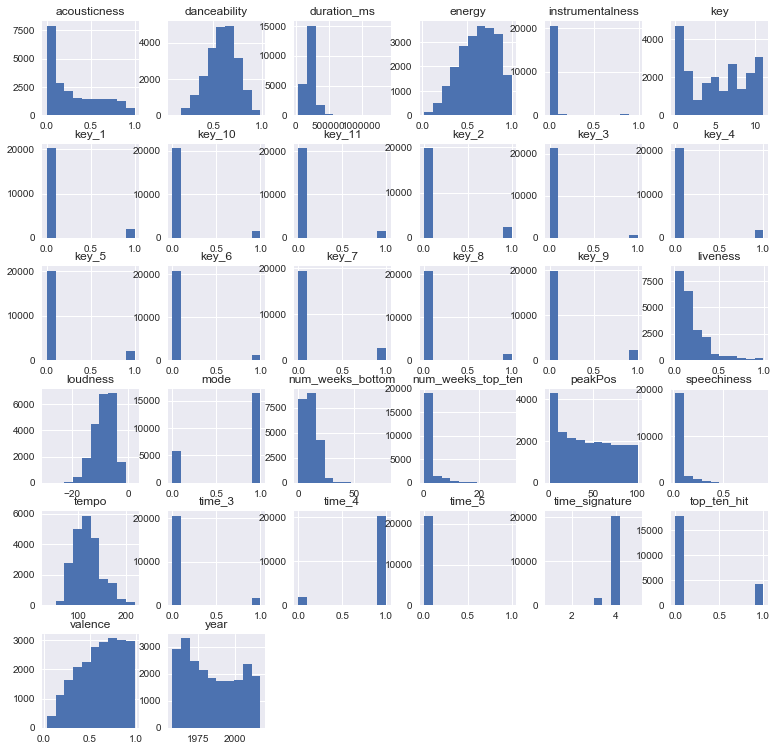

In [9]:
# Univariate Histograms
top_ten_no_na_dum.hist(figsize=(13, 13))
plt.show()

We've already discussed these distributions in the data story. We also perform a box and whiskers plot.

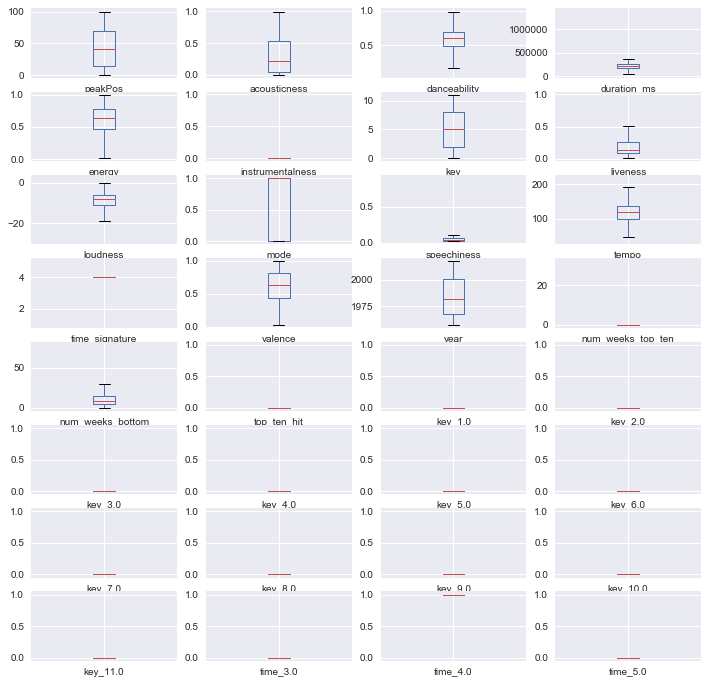

In [9]:
top_ten_no_na_dum.plot(kind='box', subplots=True,layout=(8,4), figsize=(12, 12), sharex=False, sharey=False)
plt.show()

From these observations we see there are a few outliers for the duration variable. We now investigate for other outliers.

## Outlier Detection

From the distributions above we see that 'danceability', 'duration_ms', 'energy', 'loudness', and 'tempo' have distributions that appear somewhat normal so we look for outliers from these features by checking for songs with observations that are more than two standard deviations away from the means.

In [10]:
top_ten_outlier_test=top_ten_prediction[['danceability','duration_ms','energy','loudness','tempo']]

In [11]:
outliers=pd.DataFrame()
for column in top_ten_outlier_test.columns:
    mean = np.mean(top_ten_outlier_test[column], axis=0)
    sd = np.std(top_ten_outlier_test[column], axis=0)
    column_outliers_small=top_ten_outlier_test[top_ten_outlier_test[column]< mean-2*sd]
    column_outliers_large=top_ten_outlier_test[top_ten_outlier_test[column]> mean+2*sd]
    outliers=pd.concat([outliers,column_outliers_small],axis=0)
    outliers=pd.concat([outliers,column_outliers_large],axis=0)

In [12]:
len(outliers)

4159

We obtain 4159 songs with outlier data. Since this is still a rather large amount of data with respect to the overall size of the dtaset, we do not remove these songs from our dataset.

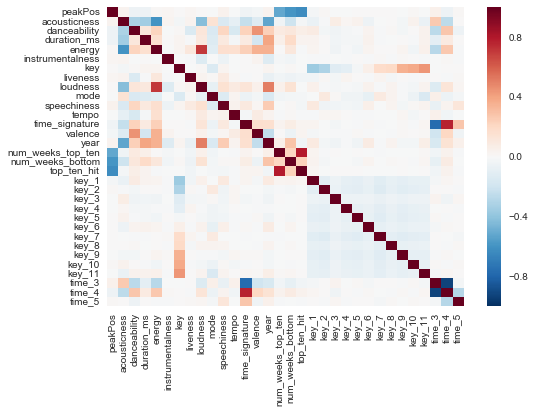

In [13]:
corr = top_ten_no_na_dum.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

From this we see a high positive correlation between energy and loudness and high negative correlation between acousticness and both loudness and energy. 

We also have that peakPos and num_weeks_top_ten will completely determine if a song is a top ten hit so we must remove them from our model. We also drop time_signature and key since these are explained by the dummy variables.

In [14]:
top_ten_no_na_dum.drop(['peakPos','num_weeks_top_ten','key','time_signature'],axis=1,inplace=True)
linear_feature_cols = ['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','mode','speechiness','tempo','valence','key_1','key_2','key_3','key_4','key_5','key_7','key_8','key_9','key_10','key_11','time_3','time_4','time_5','num_weeks_bottom']

## VIF Variance Inflation Factor

The Correlation matrix above is used to detect colinearity between two variables. However, multicolinearity is a measurement of correlation from three or more variables and can emerge even when isolated pairs of variables are not colinear.

We use the Variance Inflation Factor (VIF) as a measure of colinearity among predictor variables within a multiple regression. It is given by the formula: $ VIF = 1 / (1 - R^2). $

In [17]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

feature_cols_str = "+".join(linear_feature_cols)
# get y and X dataframes based on this regression:
y_vif, X_vif = dmatrices('top_ten_hit ~' + feature_cols_str, top_ten_no_na_dum, return_type='dataframe')
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns
vif

,VIF Factor,features
0,366,Intercept
1,2,acousticness
2,2,danceability
3,1,duration_ms
4,4,energy
5,1,instrumentalness
6,1,liveness
7,2,loudness
8,1,mode
9,1,speechiness


Note that we obtain integer values for our VIF Factors since the key and time features are now integers. We see that there is some degree of multi-colinearity between time_3 and time_4. Over 90% of songs were in 4/4 time so it will not be a very good predictor feature so we remove it from our dataset.

In [19]:
top_ten_no_na_dum.drop(['time_4'],axis=1,inplace=True)

# Machine Learning Modeling Phase

In [20]:
# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [21]:
sum(top_ten_prediction.top_ten_hit)/len(top_ten_prediction)*100

19.390656736628301

From this we see that 19.390% of the songs in our dataset are top ten hits. Thus, when modeling we can obtain an 80.609% accuracy score just by always predicting that the song is not a top ten hit. 

We have that 'top_ten_hit' is the target variable in our classification problem. To account for this imbalance in positive and negative samples we use StratifiedShuffleSplit to ensure that relative class frequencies are approximately preserved in each train and validation fold.

# Classification Algorithms
We first create an algorithm using GridSearch to optimize the parameters in the cross-validation stage. We will initially use 5-fold cross-validation. 

In [22]:
# Given a set of hyperparameters and training data we use Grid Search to find the best choice of hyperparameters
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

We write the following classification algorithm that we can use with multiple machine learning models given a dataset, target variable and hyperparameters.

In [23]:
# We use a 75-25 Train-Test split by default and do not standardize the audiodata metadata features
# We set the seed to 7 to obtain consistent results
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.75,seed = 7):
    #To create the 'X' dataset we first standardize by the mean and standard deviation is standardize is set to True
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    #Create the 'X' and 'y' datasets
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    #Split X and y into training and test data.
    # Here we implement the Stratified ShuffleSplit with n_splits =3 to account for  the discrepancy 
    # between the number of positive and negative samples.
    sss = StratifiedShuffleSplit(n_splits=3, test_size=1-train_size, random_state=seed)
    for train_index, test_index in sss.split(X,y):
        Xtrain, Xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        #Now implement GridSearchCV for the cross validation step 
        clf = cv_optimize(clf, parameters, Xtrain, ytrain)
        #Use the classifier to fit the training data
        clf=clf.fit(Xtrain, ytrain)
        training_accuracy = clf.score(Xtrain, ytrain)
        test_accuracy = clf.score(Xtest, ytest)
        print("Accuracy on training data: {:0.5f}".format(training_accuracy))
        print("Accuracy on test data:     {:0.5f}".format(test_accuracy))
        test_prediction=clf.predict(Xtest)
        print(confusion_matrix(ytest,test_prediction))
        print(classification_report(ytest,test_prediction))
    return clf, Xtrain, ytrain, Xtest, ytest

Since our question is primarily a binary classification problem, Linear Regression is not a recommended model to use so we begin with Logistic Regression.

# Logistic Regression

In [25]:
linear_feature_cols = ['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','mode','speechiness','tempo','valence','key_1','key_2','key_3','key_4','key_5','key_7','key_8','key_9','key_10','key_11','time_3','time_5','num_weeks_bottom']
from sklearn.linear_model import LogisticRegression
params = {"C": [0.001, 0.1, 1, 10, 100]}
clf_log, Xtrain_log, ytrain_log, Xtest_log, ytest_log  = do_classify(LogisticRegression(), 
                                                           params, 
                                                           top_ten_no_na_dum, linear_feature_cols, 'top_ten_hit',1)

BEST PARAMS {'C': 0.001}
Accuracy on training data: 0.80609
Accuracy on test data:     0.80610
[[4465    0]
 [1074    0]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      4465
          1       0.00      0.00      0.00      1074

avg / total       0.65      0.81      0.72      5539



C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


BEST PARAMS {'C': 0.001}
Accuracy on training data: 0.80609
Accuracy on test data:     0.80610
[[4465    0]
 [1074    0]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      4465
          1       0.00      0.00      0.00      1074

avg / total       0.65      0.81      0.72      5539



C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


BEST PARAMS {'C': 0.001}
Accuracy on training data: 0.80609
Accuracy on test data:     0.80610
[[4465    0]
 [1074    0]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      4465
          1       0.00      0.00      0.00      1074

avg / total       0.65      0.81      0.72      5539



C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


** We  see that even after implementing stratification we still obtain a logistic regrssion model that always predicts that a song will not be a Top Ten hit. Thus we do not improve upon the accuracy of the trivial prediction model.**

In [26]:
pd.options.display.float_format = '{:20,.5f}'.format
pd.DataFrame({"feature":linear_feature_cols,"log_coefficient":clf_log.coef_[0]})

,feature,log_coefficient
0,acousticness,-0.00015
1,danceability,-0.00005
2,duration_ms,-0.00000
3,energy,-0.00011
4,instrumentalness,-0.00002
5,liveness,-0.00008
6,loudness,0.00196
7,mode,-0.00020
8,speechiness,-0.00002
9,tempo,-0.01089


** The larget influence from these features comes from tempo where faster songs are very slightly less likely to make the top ten. In this model Loudness has a slight positive influence on chart performance. **

## Ridge Regression, Lasso Regression and Elastic Net Regression
Since we have a classification problem, and these models are linear in nature we do not implement them here.

# Decision Tree
In a Decision Tree we have a number of parameters we can tune. 
- Criterion measures the quality of the split by either entropy or the Gini impurity. Entropy chooses splits in the tree that result in the purest daughter nodes, whereas Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. 
- Max depth is the maximum depth of the tree or the max number of branches a node can be from the root.
- Max features is the maximum number of variables we may use in the tree.
- min_samples_leaf is the minimum of observations required to be at a leaf node. 
- min_samples_split is the minimum number of samples required to split an internal node.

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
feature_cols = ['acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','year']
params ={'criterion': ["gini","entropy"],
 'max_depth': [3, 10,12],
 'max_features': [3, 10,14],
 'min_samples_leaf': [ 3,10],
 'min_samples_split': [3,10]}
clf_dtree, Xtrain_dtree, ytrain_dtree, Xtest_dtree, ytest_dtree  = do_classify(DecisionTreeClassifier(), 
                                                           params, 
                                                           top_ten_prediction, feature_cols, 'top_ten_hit',1)

BEST PARAMS {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 3}
Accuracy on training data: 0.80621
Accuracy on test data:     0.80592
[[4464    1]
 [1074    0]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      4465
          1       0.00      0.00      0.00      1074

avg / total       0.65      0.81      0.72      5539

BEST PARAMS {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 3}
Accuracy on training data: 0.80609
Accuracy on test data:     0.80610
[[4465    0]
 [1074    0]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      4465
          1       0.00      0.00      0.00      1074

avg / total       0.65      0.81      0.72      5539



C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


BEST PARAMS {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 3}
Accuracy on training data: 0.80609
Accuracy on test data:     0.80610
[[4465    0]
 [1074    0]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      4465
          1       0.00      0.00      0.00      1074

avg / total       0.65      0.81      0.72      5539



C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


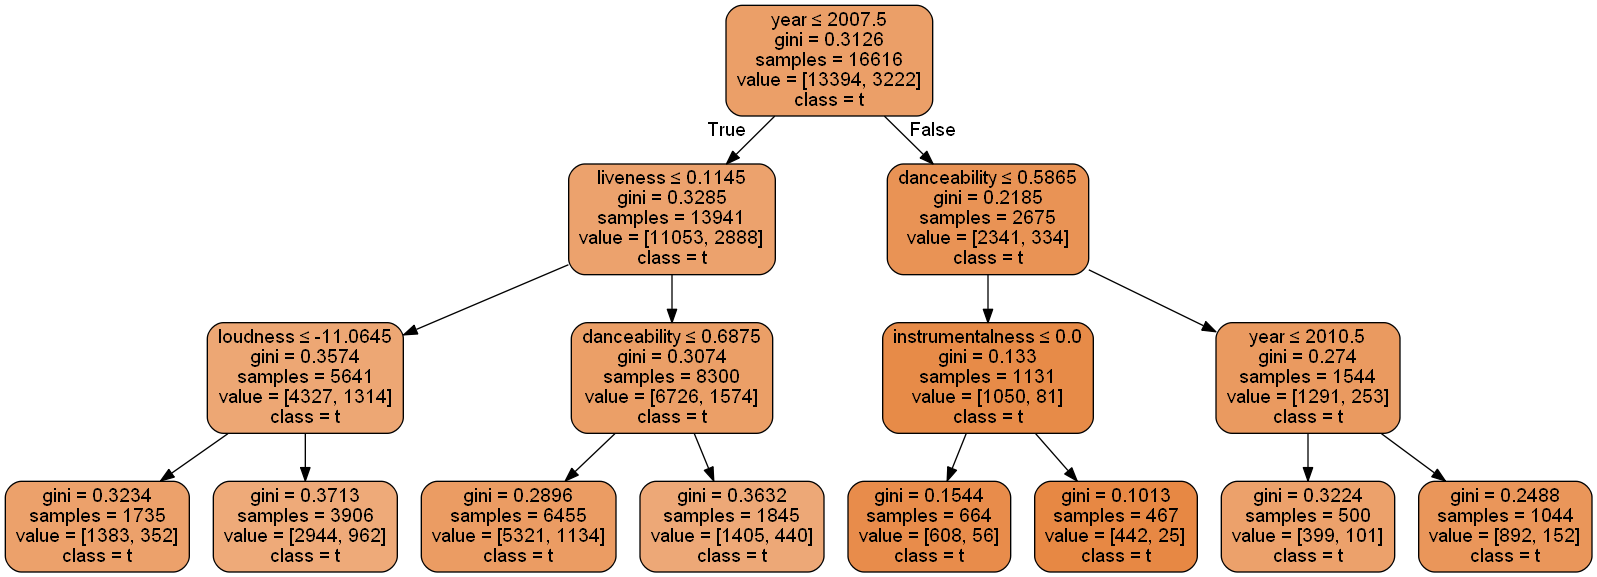

In [28]:
from IPython.display import Image 
import pydotplus
dot_data = export_graphviz(clf_dtree, out_file=None, 
                         feature_names=feature_cols,  
                         class_names='top_ten_hit',  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

** Here the Decision Tree model does not improve on the trivial accuracy as we can see from the confusion matrix. 
In our tree we see that year is the root with loudness, valence, acousticness, duration and energy also being determining factors. However, the model only predicts that songs will not be top ten hits.**

# Random Forest
A random forest is an ensemble method that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control for over-fitting.

In [29]:
from sklearn.ensemble import RandomForestClassifier
params={'n_estimators':[500,1000]}
clf_rf, Xtrain_rf, ytrain_rf, Xtest_rf, ytest_rf  = do_classify(RandomForestClassifier(), 
                                                           params, 
                                                           top_ten_prediction, feature_cols, 'top_ten_hit',1)

BEST PARAMS {'n_estimators': 500}
Accuracy on training data: 0.99741
Accuracy on test data:     0.80664
[[4446   19]
 [1052   22]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      4465
          1       0.54      0.02      0.04      1074

avg / total       0.76      0.81      0.73      5539

BEST PARAMS {'n_estimators': 500}
Accuracy on training data: 0.99765
Accuracy on test data:     0.80520
[[4440   25]
 [1054   20]]
             precision    recall  f1-score   support

          0       0.81      0.99      0.89      4465
          1       0.44      0.02      0.04      1074

avg / total       0.74      0.81      0.73      5539

BEST PARAMS {'n_estimators': 500}
Accuracy on training data: 0.99747
Accuracy on test data:     0.80538
[[4444   21]
 [1057   17]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      4465
          1       0.45      0.02      0.03      1074

avg / total     

In [30]:
pd.DataFrame({"feature":feature_cols,"feature_importance":clf_rf.feature_importances_})

,feature,feature_importance
0,acousticness,0.08839
1,danceability,0.08965
2,duration_ms,0.09221
3,energy,0.08493
4,instrumentalness,0.06002
5,key,0.04819
6,liveness,0.08752
7,loudness,0.08965
8,mode,0.01131
9,speechiness,0.08705


** We finally obtain a model different that the trivial one for prediction although we do not see any improvement in the accuracy. Here the most notable features are danceability, duration, loudness and tempo although they have a relatively small importance since they are all less than 10%.**

# Support Vector Machine Classification

Support vector machines  are a set of supervised learning methods used for classification, regression and outliers detection. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier.

For the parameters:
- C is the penalty parameter of the error term.
- degree is the degree of the polynomial kernel function.
- gamma is the kernel coefficient and when it is ‘auto’ then 1/n_features will be used.
- cache_size specifies the size of the kernel cache (in MB).
- max_iter when set to -1 mean there is no limit on the number of iterations within the solver.

In [31]:
from sklearn.svm import SVC
params ={'C':[1],
 'cache_size':[200],
 'degree':[3],
 'gamma':['auto'],
 'max_iter':[-1],
 'tol':[0.001]}
clf_svc, Xtrain_svc, ytrain_svc, Xtest_svc, ytest_svc  = do_classify(SVC(), 
                                                           params, 
                                                           top_ten_prediction, feature_cols, 'top_ten_hit',1)

BEST PARAMS {'C': 1, 'cache_size': 200, 'degree': 3, 'gamma': 'auto', 'max_iter': -1, 'tol': 0.001}
Accuracy on training data: 0.99585
Accuracy on test data:     0.80682
[[4451   14]
 [1056   18]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      4465
          1       0.56      0.02      0.03      1074

avg / total       0.76      0.81      0.73      5539

BEST PARAMS {'C': 1, 'cache_size': 200, 'degree': 3, 'gamma': 'auto', 'max_iter': -1, 'tol': 0.001}
Accuracy on training data: 0.99615
Accuracy on test data:     0.80610
[[4448   17]
 [1057   17]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      4465
          1       0.50      0.02      0.03      1074

avg / total       0.75      0.81      0.73      5539

BEST PARAMS {'C': 1, 'cache_size': 200, 'degree': 3, 'gamma': 'auto', 'max_iter': -1, 'tol': 0.001}
Accuracy on training data: 0.99585
Accuracy on test data:     0.80628
[[4451

** Support Vector Machine classification does use a model different than the trivial prediction model, with a very slight improvement on the accuracy. **

# KNN 
The k-Nearest Neighbor (KNN) algorithm is used for classification or regression. During the training phase the KNN algorithm finds the $k$ “nearest” points to a given point, and returns the class with the highest proportion. If $k = 1$, then one only looks for the closest point and returns its class. The optimal value for $k$ in KNN is usually between 3-10. In our case $k$ is given by the parameter 'n_neighbors'.

In [32]:
from sklearn.neighbors import KNeighborsClassifier
params ={'n_neighbors':[3,5,10]}
clf_knn, Xtrain_knn, ytrain_knn, Xtest_knn, ytest_knn  = do_classify(KNeighborsClassifier(), 
                                                           params, 
                                                           top_ten_prediction, feature_cols, 'top_ten_hit',1)

BEST PARAMS {'n_neighbors': 10}
Accuracy on training data: 0.80790
Accuracy on test data:     0.80159
[[4436   29]
 [1070    4]]
             precision    recall  f1-score   support

          0       0.81      0.99      0.89      4465
          1       0.12      0.00      0.01      1074

avg / total       0.67      0.80      0.72      5539

BEST PARAMS {'n_neighbors': 10}
Accuracy on training data: 0.80778
Accuracy on test data:     0.80213
[[4435   30]
 [1066    8]]
             precision    recall  f1-score   support

          0       0.81      0.99      0.89      4465
          1       0.21      0.01      0.01      1074

avg / total       0.69      0.80      0.72      5539

BEST PARAMS {'n_neighbors': 10}
Accuracy on training data: 0.80772
Accuracy on test data:     0.80357
[[4447   18]
 [1070    4]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      4465
          1       0.18      0.00      0.01      1074

avg / total       0.69

** The K-Nearest Neighbors gives a model of simililar accuracy but does not improve on the trivial model. **

# Neural Network

For a supervised nueral network model we use Multi-layer Perceptron. It is a supervised learning algorithm that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where m is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. 

Multi-layer Perceptron is sensitive to feature scaling, so we will scale the data. 

For the neural network we will only define the hidden_layer_sizes. For this parameter you pass in a tuple consisting of the number of neurons you want at each layer, where the nth entry in the tuple represents the number of neurons in the nth layer of the MLP model. There are many ways to choose these numbers, but for simplicity we will choose 3 layers with the same number of neurons as there are features in our dataset.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
X=top_ten_prediction[feature_cols].values
y=top_ten_prediction['top_ten_hit'].values
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.25, random_state=7)
for train_index, test_index in sss.split(X,y):
    Xtrain_nn, Xtest_nn = X[train_index], X[test_index]
    ytrain_nn, ytest_nn = y[train_index], y[test_index]
    # For the neural network we add the extra scaling step:
    scaler = StandardScaler()
    # Fit only to the training data
    scaler.fit(Xtrain_nn)
    X_train_nn = scaler.transform(Xtrain_nn)
    X_test_nn = scaler.transform(Xtest_nn)
    #Use the classifier to fit the training data. We have 14 variables in our set
    mlp = MLPClassifier(hidden_layer_sizes=(14,14,14))
    mlp.fit(X_train_nn,ytrain_nn)
    training_accuracy = mlp.score(X_train_nn, ytrain_nn)
    test_accuracy = mlp.score(X_test_nn, ytest_nn)
    print("Accuracy on training data: {:0.5f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.5f}".format(test_accuracy))
    predictions = mlp.predict(X_test_nn)
    print(confusion_matrix(ytest_nn,predictions))
    print(classification_report(ytest_nn,predictions))

** In this model we obtain a slight improvement on the trivial model. Another downside to using a Multi-Layer Preceptron model is that it is difficult  to interpret the model itself. The weights and biases won't be easily interpretable in relation to which features are important to the model itself. We can look at the attribute 'coefs_'  to see a list of weight matrices, where weight matrix at index $i$ represents the weights between layer $i$ and layer $i+1$.**

# GBM Tree

Gradient Boosting is a sequential technique which works on the principle of ensemble. It combines a set of weak learners and delivers improved prediction accuracy. 

- learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators. We want to choose a relatively high learning rate.
- min_samples_split is the minimum number of samples required to split an internal node and should be around ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
- min_samples_leaf is the minimum number of samples required to be at a leaf node and is used to prevent overfitting. We choose a small value again because of imbalanced classes.
- max_depth limits the number of nodes in the tree.
- max_features is the number of features to consider when looking for the best split. A general rule of thumb is to start with square root.

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
params ={'learning_rate':[0.05,0.1,0.2], 
         'min_samples_split':[150],
         'min_samples_leaf':[50],
         'max_depth':[3,5],
         'max_features':['sqrt']}
clf_gbm, Xtrain_gbm, ytrain_gbm, Xtest_gbm, ytest_gbm  = do_classify(GradientBoostingClassifier(), 
                                                           params, 
                                                           top_ten_prediction, feature_cols, 'top_ten_hit',1)

BEST PARAMS {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 50, 'min_samples_split': 150}
Accuracy on training data: 0.80621
Accuracy on test data:     0.80610
[[4464    1]
 [1073    1]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      4465
          1       0.50      0.00      0.00      1074

avg / total       0.75      0.81      0.72      5539

BEST PARAMS {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 50, 'min_samples_split': 150}
Accuracy on training data: 0.80609
Accuracy on test data:     0.80610
[[4465    0]
 [1074    0]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      4465
          1       0.00      0.00      0.00      1074

avg / total       0.65      0.81      0.72      5539



C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


BEST PARAMS {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 50, 'min_samples_split': 150}
Accuracy on training data: 0.80609
Accuracy on test data:     0.80610
[[4465    0]
 [1074    0]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      4465
          1       0.00      0.00      0.00      1074

avg / total       0.65      0.81      0.72      5539



C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
pd.DataFrame({"feature":feature_cols,"feature_importance":clf_gbm.feature_importances_})

,feature,feature_importance
0,acousticness,0.06840
1,danceability,0.13372
2,duration_ms,0.15002
3,energy,0.03947
4,instrumentalness,0.05027
5,key,0.01204
6,liveness,0.05750
7,loudness,0.04998
8,mode,0.00918
9,speechiness,0.05401


** Here we see that year is the most important feature, which makes sense since we have seen that the average value of many of the audio metadata features varied over time. In terms of audio metadata features we find that danceability and duration are the two most significant features in this dataset. **

# Conclusion
From our machine learning models we find that danceability and duration are the most consistent predictors of song popularity whereas time signature is not a very good predictor.

However, none of our models were able to make significant improvements on the  trivial prediction criterion.